In [1]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

Dataset URL: https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images
License(s): CC0-1.0
  0% 0.00/98.7M [00:00<?, ?B/s]
100% 98.7M/98.7M [00:00<00:00, 1.38GB/s]


Found 9605 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Epoch 1/12
301/301 ━━━━━━━━━━━━━━━━━━━━ 192s 612ms/step - accuracy: 0.7256 - loss: 0.5803 - val_accuracy: 0.8750 - val_loss: 0.2898 - learning_rate: 0.0010
Epoch 2/12
301/301 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8467 - loss: 0.3529 - val_accuracy: 0.8950 - val_loss: 0.2620 - learning_rate: 0.0010
Epoch 3/12
301/301 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8667 - loss: 0.3131 - val_accuracy: 0.8870 - val_loss: 0.2445 - learning_rate: 0.0010
Epoch 4/12
301/301 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8718 - loss: 0.3010 - val_accuracy: 0.8930 - val_loss: 0.2525 - learning_rate: 0.0010
Epoch 5/12
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8800 - loss: 0.2866
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
301/301 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8800 - loss: 0.2866 - val_accuracy: 0.8930 - val_loss: 0.2593 - learning_rate: 0

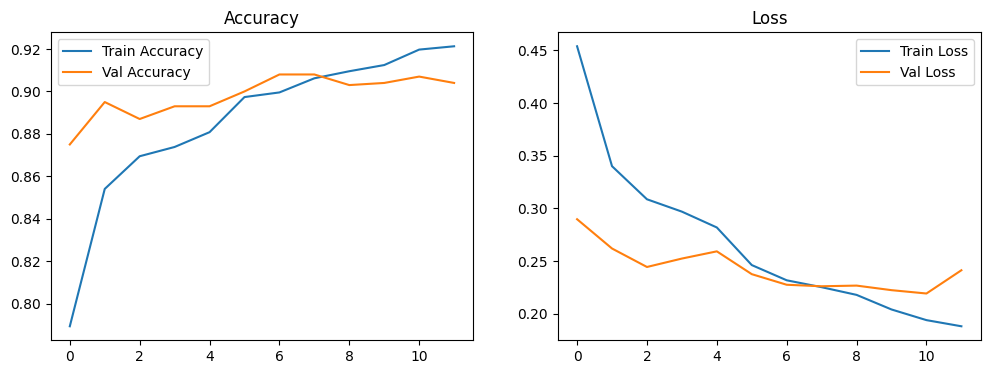

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import zipfile
import os

# Step 1: Unzip dataset
zip_path = '/content/melanoma-skin-cancer-dataset-of-10000-images.zip'
extract_path = '/content/melanoma_cancer_dataset'
file_path = '/content/melanoma_cancer_dataset/melanoma_cancer_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define paths to train and test directories
train_path = os.path.join(file_path, 'train')
test_path = os.path.join(file_path, 'test')

# Step 2: Set parameters
img_height, img_width = 224, 224
batch_size = 32

# Step 3: Load training and test datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=123,
    label_mode='binary'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    label_mode='binary'
)

# Step 4: Data augmentation + normalization
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
])

normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply augmentation only on training set
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# Only normalize validation set (no augmentation)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Step 5: Build a custom CNN
inputs = Input(shape=(img_height, img_width, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=output)

# Step 6: Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Step 7: Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1)
]

# Step 8: Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12,
    callbacks=callbacks
)

# Step 9: Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [3]:
model.save('melanoma_model3.h5')